# Informed Search Algorithms

Informed search algorithms differ from blind search algorithms in the sense that the goal state is already known. Additionally, the algorithms use knowledge during the search in order to guide the search. This knowledge can take the form of distance to target, or incurred costs.

In [1]:
# Setup the Graph, origin, and destination
import osmnx
from smart_mobility_utilities.common import Node
from smart_mobility_utilities.viz import draw_route

reference = (43.661667, -79.395)
G = osmnx.graph_from_point(reference, dist=500, clean_periphery=True, simplify=True)
origin = Node(graph=G, osmid=1907446268)
destination = Node(graph=G, osmid=1633421938)

---

## Hill Climbing

The idea of the algorithm is quite simple: 

Starting with a known (non-optimized) solution to a function, the algorithm checks the neighbours of that solution, and chooses the neighbour that is "more" optimized. The process is repeated until no "better" solution can be found, at which point the algorithm terminates.

While the algorithm works relatively well with **convex** problems, functions with multiple local maxima will often result in an answer that is not the global maximum. It also performs poorly when there are plateaus (a local set of solutions that are all similarly optimized).

<style>
i {font-weight:normal}
span {font-weight:normal}
</style>

<div style="background-color: rgba(0,0,0,0.0470588);padding:10px;font-family:monospace;">
    <b>HILL-CLIMBING</b>(<i>source</i>,<i>destination</i>) <b>return</b> a <i>route</i>
    <div style='padding-left:20px;'>
        <i><font color="green">current</font></i> &larr; random <i>route</i> from <i>source</i> to <i>destination</i><br>
        <i><font color="orange">neighbours</font></i> &larr; children of <i><font color="green">current</font></i><br><br>
        while min(<i><font color="orange">neighbours</font></i>) < <i><font color="green">current</font></i> do
        <div style='padding-left:20px;'>
            <i><font color="green">current</font></i> &larr; min(<i><font color="orange">neighbours</font></i>)<br>
            <i><font color="orange">neighbours</font></i> &larr; children of <i><font color="green">current</font></i>
        </div>
        return <i><font color="green">current</font></i>
    </div>
</div>
<br><br>

Here, we introduce a few new ideas. 

First, we treat the route between two nodes as a function, the value of which is the distance between the two nodes.
Second, we generate "children" of this function.

---

### The function
We need to define a function $f$ that is our target for optimization. <br><br>
$f(x)$ gives us the length of a route for some given route $x \in Y$, where $Y$ is the set of all possible routes between two specific nodes.

How do we generate $x$? We could just generate random permutations between the two nodes, filtering for permutations that are feasible, and optimize $f$ over these random, sparse permutations.

However, this method is not reproducible (because the permutations change every run).

Instead, we make a deterministic policy that generates a number of $x \in Y$ by successively "failing" nodes between the source and destination nodes. We then find the shortest path between the nodes before and after the "failed" nodes. 

By failing the nodes in a deterministic fashion, we can say that we have a function and neighbourhood with defined size for a certain value so we can "rigorously" conduct a local search.

To generate our initial route and children routes, we will use the `smart_mobility_utilities` package. You can see how these routes are generated by consulting the documentation for that package.

:::{note}
The implementation below uses a function called `get_children` which is located in the `smart_mobility_utilities.children` library. It offers both normal and multiprocessed versions in order to speed up processing time. 

We will be using the multiprocessing version of the function, as it performs with approximately 80% processing time reduction.
:::

Initial cost: 1276.422
Initial min(children): 1082.48
Current cost: 1082.48 | min(children): 1076.86
Current cost: 1076.86 | min(children): 1082.48
Final cost: 1076.86


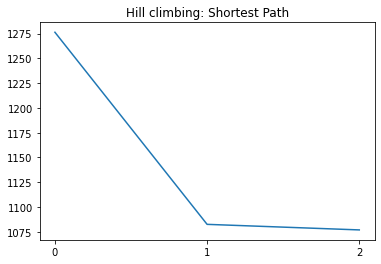

In [2]:
from smart_mobility_utilities.common import randomized_search, cost
from smart_mobility_utilities.children import get_children
import matplotlib.pyplot as plt

# Visualize the costs over time
costs = []
# Set the number of children to generate
num_children = 20

current = randomized_search(G, origin.osmid, destination.osmid)
costs.append(cost(G,current))
print("Initial cost:",costs[0])

neighbours = get_children(G,current,num_children=num_children, multiprocessing=True, workers=6)
shortest = min(neighbours , key = lambda route : cost(G, route))

print("Initial min(children):",cost(G,shortest))
while cost(G, shortest) < cost(G, current):
    current = shortest
    neighbours = get_children(G,current,num_children=num_children, multiprocessing=True, workers=6)
    shortest = min(neighbours , key = lambda route : cost(G, route))
    costs.append(cost(G,current))
    print(f"Current cost:",costs[-1],"|","min(children):",cost(G, shortest))

route = current

plt.xticks(range(len(costs)))
plt.title("Hill climbing: Shortest Path")
p = plt.plot(costs)
print("Final cost:",costs[-1])



In [3]:
draw_route(G,route)

KeyboardInterrupt: 

While the implementation above is deterministic in nature, the initial route is still randomized. That means that it's possible to get different results across runs.

Hill climbing will generally return some decent results as there are few local optimal points in the route function. However, with larger search spaces that will naturally have more local maxima and plateaus, it will get stuck fairly quickly.

---

## Beam Search

While Hill Climbing maintains a single "best" state throughout the run, beam search keeps $k$ states in memory. At each iterations, it generates the neighbours for each of the $k$ states, and puts them into a pool with the $k$ states from the original beam. It then selects the best $k$ routes from the pool to become the new beam, and this process repeats. The algorithm terminates when the new beam is equal to the old beam. As it is a local search algorithm, it is also susceptible to being stuck at local maxima.

A beam search with $k=\infty$ is the same as a BFS. Because there is the risk that a state that would lead to the optimal solution might get discarded, beam searches are considered to be incomplete (it may not terminate with the solution).

<style>
i {font-weight:normal}
span {font-weight:normal}
</style>

<div style="background-color: rgba(0,0,0,0.0470588);padding:10px;font-family:monospace;">
    <b>BEAM-SEARCH</b>(<i>source</i>,<i>destination</i>,<i>k</i>) <b>return</b> a <i>route</i>
    <div style='padding-left:20px;'>
        <i><font color="green">seen</font></i> &larr; <i>nil</i><br>
        <i><font color="orange">beam</font></i> &larr; random <i>k</i> routes from <i>source</i> to <i>destination</i><br>
        add <i><font color="orange">beam</font></i> to <i><font color="green">seen</font></i><br>
        <i><font color="purple">pool</font></i> &larr; children of routes in the <i><font color="orange">beam</font></i> with consideration of <i><font color="green">seen</font></i> + <i><font color="orange">beam</font></i><br>
        <i><font color="grey">last_beam</font></i> &larr; <i>nil</i><br><br>
        while <i><font color="orange">beam</font></i> is not <i><font color="grey">last_beam</font></i> do
        <div style='padding-left:20px;'>
            <i><font color="grey">last_beam</font></i> &larr; <i><font color="orange">beam</font></i><br>
            <i><font color="orange">beam</font></i> &larr; the best <i>k</i> routes from <i><font color="purple">pool</font></i><br>
            add <i><font color="orange">beam</font></i> to <i><font color="green">seen</font></i><br>
            <i><font color="purple">pool</font></i> &larr; children of routes in the <i><font color="orange">beam</font></i> with consideration of <i><font color="green">seen</font></i> + <i><font color="orange">beam</font></i>
        </div>
        <b>return</b> optimal <i>route</i> in <i><font color="orange">beam</font></i>
    </div>
</div>
<br><br>

:::{note}
The implementation below uses a function called `get_beam` which is located in the `smart_mobility_utilities.children` library. It offers both normal and multiprocessed versions in order to speed up processing time. 

We will be using the multiprocessing version of the function, as it performs with approximately 50% processing time reduction.
:::

Route: [1907446268, 55808224, 55808227, 8699043521, 55808177, 55808169, 55808239, 389678268, 4953810915, 389678267, 24960090, 389678273, 1258698113, 1258698109, 389678145, 24960070, 24960073, 7311083154, 50885160, 389678121, 50885147, 389678122, 389677906, 50885141, 389678180, 2143436415, 2143436407, 2143436406, 2143436381, 389678041, 389678184, 389678183, 24959556, 389678214, 389678215, 389678226, 1633421933, 1633421938]
Cost: 1059.537


Text(0.5, 1.0, 'Beam Search: Costs vs time')

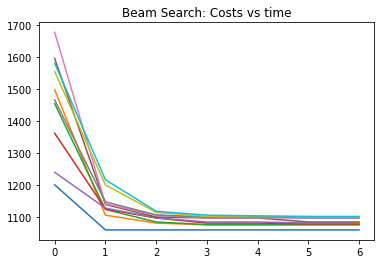

In [ ]:
import heapq
from smart_mobility_utilities.children import get_beam
import matplotlib.pyplot as plt

# Initialize
seen = set()
k = 10
num_neighbours = 10
costs = []

beam = [randomized_search(G,origin.osmid,destination.osmid) for _ in range(k)]

# the seen routes must be converted to a tuple to be hashable to be stored in a set
for route in beam: seen.add(tuple(route))

pool = []
children = get_beam(G,beam,num_neighbours,multiprocessing=True,workers=6)
costs.append([cost(G,r) for r in beam])
for child in children:
    for r in child:
        if tuple(r) in seen: continue
        else: 
            pool.append(r)
            seen.add(tuple(r))
pool += beam
last_beam = None
while beam != last_beam:
    last_beam = beam
    beam = heapq.nsmallest(k, pool, key = lambda route: cost(G, route))
    
    for route in beam: seen.add(tuple(route))    
    
    pool = []
    children = get_beam(G,beam,num_neighbours,multiprocessing=True,workers=6)
    costs.append([cost(G,r) for r in beam])
    for child in children:
        for r in child:
            if tuple(r) in seen: continue
            else: pool.append(r); seen.add(tuple(r))
    pool += beam   
route = min(beam, key = lambda route : cost(G, route)) 


print("Route:",route)
print("Cost:", cost(G,route))

costs = map(list,zip(*costs))
for c in costs:
    plt.plot(c)
plt.title("Beam Search: Costs vs time")

In [ ]:
draw_route(G,route)

Map(center=[43.6611082, -79.3947681], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_titl…

---

## A* Search
A* (pronounced A-star) search is an informed search algorithm widely used in pathfinding and graph traversal.

A* works by "greedily" choosing which vertex to explore next, based on a function:

$f(V) = h(V) + g(V)$, where $h$ is a heuristic, and $g$ is the cost accrued up to that point.

<style>
i {font-weight:normal}
span {font-weight:normal}
</style>

<div style="background-color: rgba(0,0,0,0.0470588);padding:10px;font-family:monospace;">
    <b>A* Heuristic</b> &larr; sum of straight-line distance between the node to source and node to destination<br>
    <b>PQ</b> &larr; min heap according to <b>A* Heuristic</b><br><br>
    <b>A*-SEARCH</b>(<i>source</i>,<i>destination</i>) <b>return</b> a <i>route</i>
    <div style='padding-left:20px;'>
        <i><font color="green">frontier</font></i> &larr; a <b>PQ</b> initialized with <i>source</i><br>
        <i><font color="grey">explored</font></i> &larr; <i>empty</i><br>
        <i><font color="orange">found</font></i> &larr; <i>False</i><br>
        while <i><font color="green">frontier</font></i> is not <i>empty</i> and <i><font color="orange">found</font></i> is <i>False</i> do
        <div style='padding-left:20px;'>
        <i>node</i> &larr; <i><font color="green">frontier</font></i>.pop()<br>
        add <i>node</i> to <i><font color="grey">explored</font></i><br>
        for <i>child</i> in <i>node</i>.expand() do
            <div style='padding-left:20px;'>
                if <i>child</i> is not in <i><font color="grey">explored</font></i> and <i>child</i> is not in <i><font color="green">frontier</font></i> then
                <div style='padding-left:20px;'>
                if <i>child</i> is <i>destination</i> then
                    <div style='padding-left:20px;'>
                        <i>route</i> &larr; <i>child</i>.route()<br>
                        <i><font color="orange">found</font></i> &larr; <i>True</i>
                    </div>
                add <i>child</i> to <i><font color="green">frontier</font></i>
                </div>
            </div>
        </div>
    return <i>route</i>
    </div>
</div>
<br><br>

### The Heuristic

The driving force behind A* is the selection of a new vertex (or node) to explore based on the lowest heuristic value. This heuristic value is computed by the following formula:

let $dist(x,y)$ be a function that calculates the straight line distance between two nodes $x,y$,<br>
and let $O$ be the origin node, and $D$ be the destination node,

$h(V) = dist(V,O) + dist(V,D)$ for any given node $V$

As the sum of the distance to the origin and destination is minimized when $V$ lies on a straight line from $O$ to $D$, this heuristic prioritizes nodes which are "closer" to the straight-line distance from origin to destination.

:::{note}
The implentation of the A* heuristic in `smart_mobility_utilities` defaults to calculating distances as if the Earth were flat. For local searches, this yields the best results. If the size of the search area is larger, it is better to calculate distance using the `haversine_distance`, which takes into account the curvature of the Earth.

This can be done by setting the distance function like so:<br>
```astar_heuristic(G,origin.osmid,destination.osmid, measuring_dist = haversine_distance)```
:::

In [ ]:
# Get the A* Heuristic for all the nodes in the graph
from smart_mobility_utilities.problem import astar_heuristic

toOrigin, toDestination = astar_heuristic(G, origin.osmid, destination.osmid)

route = []

frontier = list()

frontier.append(origin)
explored = set()
found = False

while frontier and not found:    
    # choose a node based on its heuristic value
    node = min(frontier, key = lambda node : toOrigin[node.osmid] + toDestination[node.osmid])
    frontier.remove(node)
    explored.add(node)
    
    # expand its children
    for child in node.expand():
        if child not in explored and child not in frontier:
            if child == destination:
                route = child.path()
                found = True
                continue
            frontier.append(child)

print("The route is ",route)
print("Route cost is", cost(G, route))
draw_route(G,route)

The route is  [1907446268, 55808224, 55808227, 8699043521, 1907446267, 8699033082, 55808301, 6542457312, 4953810914, 55808233, 299625330, 389677953, 7967019556, 7967019555, 390547782, 389678107, 389678111, 389678112, 389678113, 389678146, 2143434862, 2143434860, 7311083158, 1258707987, 389678121, 50885147, 389678122, 1258707990, 7153999189, 389678124, 6028562355, 2557542523, 389677907, 389678038, 389678039, 389678040, 2143436381, 7311057930, 7311057931, 389678216, 389678215, 389678226, 1633421933, 1633421938]
Route cost is 1137.69


Map(center=[43.6611082, -79.3947681], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_titl…

---

## Bi-Directional Search
The purpose of bi-directional searches are to run two simultaneous, non-parallel searches; one starts at the origin and the other at the destination, with the goal of meeting somewhere in between.

This approach is more efficient because of the time complexities involved.

For example, a BFS search with a constant branching factor $b$ and depth $d$ would have an overall space complexity of $O(d^b)$. By running two BFS searches in opposite directions with only half the depth ($d/2$), the space complexity becomes instead $O((d/2)^b)+O((d/2)^b)$, which is much lower than the original $O(d^b)$.

<style>
i {font-weight:normal}
span {font-weight:normal}
</style>

<div style="background-color: rgba(0,0,0,0.0470588);padding:10px;font-family:monospace;">
    <b>BI-DIRECTIONAL-SEARCH</b>(<i>source</i>,<i>destination</i>) <b>return</b> a <i>route</i>
    <div style='padding-left:20px;'>
        <font color="#03A9F4">// _f for forward, _b for backward</font><br>
        <i><font color="green">frontier_f</font></i> &larr; initialized with <i>source</i><br>
        <i><font color="green">frontier_b</font></i> &larr; initialized with <i>destination</i><br>
        <i><font color="grey">explored_f</font></i> &larr; <i>empty</i><br>
        <i><font color="grey">explored_b</font></i> &larr; <i>empty</i><br>
        <i><font color="orange">found</font></i> &larr; <i>False</i><br>
        <i><font color="purple">collide</font></i> &larr; <i>False</i> <font color="#03A9F4">// if front overlaps with back</font><br>
        <i><font color="blue">found</font></i> &larr; <i>False</i><br>
        <i><font color="blue">altr_expand</font></i> &larr; <i>False</i><font color="#03A9F4">// expansion direction</font><br><br>
        while <i><font color="green">frontier_f</font></i> is not <i>empty</i> and <i><font color="green">frontier_b</font></i> is not <i>empty</i> and not <i><font color="purple">collide</font></i> and not <i><font color="orange">found</font></i> do
        <div style='padding-left:20px;'>
            if <i><font color="blue">altr_expand</font></i> then
            <div style='padding-left:20px;'>
                <i>node</i> &larr; <i><font color="green">frontier_f</font></i>.pop()<br>
                add <i>node</i> to <i><font color="grey">explored_f</font></i><br>
                for <i>child</i> in <i>node</i>.expand() do
                <div style='padding-left:20px;'>
                    if <i>child</i> in <i><font color="grey">explored_f</font></i> then continue<br>
                    if <i>child</i> is <i>destination</i> then
                        <div style='padding-left:20px;'>
                            <i>route</i> &larr; <i>child</i>.route()<br>
                            <i><font color="orange">found</font></i> &larr; <i>True</i>
                        </div>
                    if <i>child</i> in <i><font color="grey">explored_b</font></i> then
                        <div style='padding-left:20px;'>
                            <i>route</i> &larr; <i>child</i>.route() + reverse(<i>overlapped</i>.route())<br>
                            <i><font color="purple">collide</font></i> &larr; <i>True</i>
                        </div>
                    add <i>child</i> to <i><font color="green">frontier_f</font></i><br>
                    <i><font color="blue">altr_expand</font></i> &larr; not <i><font color="blue">altr_expand</font></i>
                </div>
            </div>
            else
            <div style='padding-left:20px;'>
                <i>node</i> &larr; <i><font color="green">frontier_b</font></i>.pop()<br>
                add <i>node</i> to <i><font color="grey">explored_b</font></i><br>
                for <i>child</i> in <i>node</i>.expand() do
                <div style='padding-left:20px;'>
                    if <i>child</i> in <i><font color="grey">explored_b</font></i> then continue<br>
                    if <i>child</i> is <i>origin</i> then
                        <div style='padding-left:20px;'>
                            <i>route</i> &larr; <i>child</i>.route()<br>
                            <i><font color="orange">found</font></i> &larr; <i>True</i>
                    </div>
                    if <i>child</i> in <i><font color="grey">explored_f</font></i> then
                        <div style='padding-left:20px;'>
                            <i>route</i> &larr; reverse(<i>child</i>.route()) + <i>overlapped</i>.route()<br>
                            <i><font color="purple">collide</font></i> &larr; <i>True</i>
                        </div>
                    add <i>child</i> to <i><font color="green">frontier_b</font></i><br>
                    <i><font color="blue">altr_expand</font></i> &larr; not <i><font color="blue">altr_expand</font></i>
                </div>
            </div>
        </div>
        return <i>route</i>
    </div>
</div>
<br><br>

In [ ]:
# Using A* as search heuristic and algorithm

# define destination and origin for the backwards expansion
destination_b = origin
origin_b = destination

# get A*
toOrigin_f, toDestination_f = astar_heuristic(G, origin.osmid, destination.osmid)
toOrigin_b, toDestination_b = astar_heuristic(G, origin_b.osmid, destination_b.osmid)

route = []

f_value = lambda node: toOrigin_f[node.osmid] + toDestination_f[node.osmid]
b_value = lambda node: toOrigin_b[node.osmid] + toDestination_b[node.osmid]

frontier_f = list()
frontier_b = list()

frontier_f.append(origin)
frontier_b.append(origin_b)

explored_f = list()
explored_b = list()

collide = False
found = False
altr_expand = False # to alternate between front and back

while frontier_f and frontier_b and not collide and not found:
   
    if altr_expand:
        # remove node_f from frontier_f to expand it
        node = min(frontier_f, key = lambda node : f_value(node))
        frontier_f.remove(node)
        explored_f.append(node)
        
        for child in node.expand():
            if child in explored_f: continue
            
            if child == destination:
                route = child.path()
                found = True
                break

            # checking for collusion with the target expansion
            if child in explored_b:
                overlapped = next((node for node in explored_b if node == child))
                # we don't take the overlapped node twice
                route = child.path()[:-1] + overlapped.path()[::-1]
                collide = True
                break

            frontier_f.append(child)
        altr_expand = False
    else:
        # remove node_b from frontier_b to expand it
        node = min(frontier_b, key = lambda node : b_value(node))
        frontier_b.remove(node)
        explored_b.append(node)
        
        for child in node.expand():
            if child in explored_b: continue
            if child == destination_b:
                route = child.path()[::-1] # we reverse the list because we expand from the back
                found = True
                break

            if child in explored_f:
                overlapped = next((node for node in explored_f if node == child), None)
                route = overlapped.path()[:-1] + child.path()[::-1]
                collide = True
                break

            frontier_b.append(child)
        altr_expand = True

print("The route is \n\n",route)
print("Cost of the route:",cost(G,route))
draw_route(G,route)

The route is 

 [1907446268, 55808224, 55808227, 8699043521, 1907446267, 8699033082, 55808301, 6542457312, 4953810914, 55808233, 299625330, 389677953, 7967019556, 7967019555, 390547782, 389678107, 389678111, 389678112, 389678113, 389678146, 2143434862, 2143434860, 7311083158, 1258707987, 389678121, 50885147, 389678122, 1258707990, 7153999189, 389678124, 6028562355, 2557542523, 389677907, 389678038, 389678039, 389678040, 2143436381, 7311057930, 7311057931, 389678216, 389678215, 389678226, 1633421933, 1633421938]
Cost of the route: 1137.69


Map(center=[43.6611082, -79.3947681], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_titl…

---

## Hierarchical Approaches

When facing routing problems at larger scales, such as those involving entire continents or graphs with millions of nodes, it is simply implausible to use basic approaches like Dijkstra or DFS. Instead, routing algorithms "prune" the search space in order to simplify the routing problem. Additionally, routing services may choose to precompute certain routes and cache them on servers, so that response times to user queries are reasonable.

Hierarchical search algorithms prune the search space by generating admissible heuristics that abstract the search space. Read more about the general approach of hierarchical methods at [Faster Optimal and Suboptimal Hierarchical Search](https://www.aaai.org/ocs/index.php/SOCS/SOCS11/paper/viewFile/4035/4363).

In this section, we'll give a brief overview of two hierarchical approaches that aim to solve the shortest path problem, and show how their heuristics are computed. There will also be a `python` implementation of the Contraction Hierarchies example.

---

### Highway Hierarchies

In this algorithm, the hierarchy "level" of each road/arc in the graph is calculated. This distinguishes the type of road segment (i.e. residential, national roads, highways). This is further supplemented by relevant data such as maximum designated driving speed, as well as number of turns in the road. After the heuristics are generated for the graph, the data is passed through a modified search function (bi-directional Dijkstra, A*, etc) that considers the distance to the destination and the potential expansion node class. 

For example, the algorithm will generally consider highways as viable expansion nodes when it is still relatively further away from the target, and then will start to include national roads, and finally residential streets as it nears the destination. 

While this approach "makes sense", there are some disadvantages. First, the algorithm largely overlooks what kind of roads humans "prefer" to drive on. That is to say, which a highway might make sense for a given route, the user may "prefer" to take local roads (i.e. driving to a friend's house who lives nearby). Secondly, highway hierarchies do not take into account factors such as traffic, which fluctuates often and adds significant cost to an "optimal" route.

You can learn more about contraction hierarchies [here](https://link.springer.com/chapter/10.1007/11561071_51).

---

### Contraction Hierarchies
While the highway hierarchies algorithm may be useful for speeding up shortest path searches, it only considers three levels of road hierarchies. On the other hand, the contraction hierarchies algorithm introduced by [Contraction Hierarchies: Faster and Simpler Hierarchical Routing in Road Networks](https://link.springer.com/chapter/10.1007/978-3-540-68552-4_24) has the same number of hierarchies as nodes in the graph, which is beneficial as increased number of hierarchies results in more pruning of the search space.

#### Contraction
Taking any node $V$ from a graph $G$, remove $V$ as well as any connected edges. <br>
Add any number of edges to $G$ such that the shortest distance for any pair of neighbouring nodes remains the same, even after $V$ has been removed. Below is an example:<br>
![](../../images/uncontract.png)

Suppose we are contracting **Node 1**. By removing the node, we have now changed the shortest path for 0&rarr;2, 0&rarr;3, and 2&rarr;3. We can restore it by creating new edges. After the creation of new edges, we then reinsert any removed nodes and edges. We then update that node with its hierarchy level (which is just the order of contraction, from $1 to n$). See the below updated graph:<br><br>
![](../../images/contract.png)

This process is then repeated for all the other nodes. In our example, no other nodes need to be contracted, as removing any one of the remaining nodes does not affect the rest of the graph in terms of shortest path. This process will form **shortcuts**, which allow us to search the graph much faster, as we can ignore certain nodes that have been "pruned".

#### Contraction Order
Any order for node contraction will result in a successful algorithm, however some contraction ordering systems minimizes the number of new edges added to the graph, and thus the overall running time.

To utilize this, we can employ the idea of **edge difference (ED)**. The ED of a node is $S-E$, where $S$ is the number of new edges added if that node were to be contracted, and $E$ is the number of edges that would be deleted. Minimizing ED is equivalent to minimizing the number of new edges added to the graph, and thus improves processing time.

---

### Example #1: Bi-directional Dijkstra with contraction

After contracting a graph, we can run a bi-directional Dijkstra to compute all the shortest paths in the graph. Following this, any queries for the shortest path between any two nodes in the graph can be solved using a cached result.

There are some restrictions for our modified Dijkstra's:

1. The forward expansion only considers arcs $u,v$, where $level(u) > level(v)$. This forms the **upward graph**, where only nodes with a higher contraction order can be relaxed.
2. The backward expansion only considers arcs $u,v$, where $level(u) < level(v)$. This forms the **downward graph**, where only nodes with a lower contraction order can be relaxed.

These restrictions help "prune" the search space and speed up the processing.

At the end, multiple paths are returned from source to destination, of which the shortest is selected to be the solution.

Let's try this with the sample graph below:

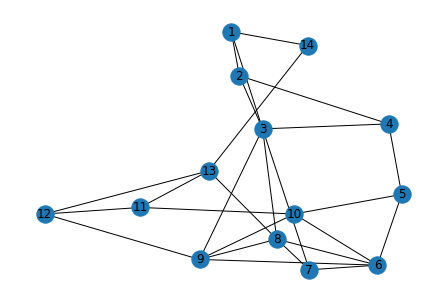

In [1]:
import networkx
import random
import math

G = networkx.Graph()

# Computing each contraction level requires a new graph, which is costly in terms of memory.
# To avoid this, we use a flag on every node to show its contraction state.

# Add 14 nodes
for i in range(1,15):
    G.add_node(i, contracted=False)

# Define the edges
edges = [
    (1,2,{'weight':1}),
    (1,3,{'weight':4}),
    (2,3,{'weight':5}),
    (2,4,{'weight':2}),
    (3,4,{'weight':2}),
    (3,7,{'weight':2}),
    (3,8,{'weight':1}),
    (3,9,{'weight':1}),
    (4,5,{'weight':5}),
    (5,10,{'weight':7}),
    (6,7,{'weight':4}),
    (6,8,{'weight':3}),
    (6,10,{'weight':3}),
    (6,5,{'weight':3}),
    (6,9,{'weight':1}),
    (7,8,{'weight':6}),
    (8,9,{'weight':3}),
    (8,13,{'weight':5}),
    (9,12,{'weight':1}),
    (9,10,{'weight':3}),
    (10,11,{'weight':4}),
    (11,12,{'weight':3}),
    (11,13,{'weight':4}),
    (12,13,{'weight':2}),
    (14,1,{'weight':3}),
    (14,13,{'weight':2})
]
# Add the edges to the graph and visualize it.
G.add_edges_from([*edges])
networkx.draw(G,with_labels=True)

:::{note}
For this implementation we will be using two helper functions from `smart_mobility_utilities.contraction`.

The first is `dijkstra_with_contraction`, which simple runs a Dijkstra search on a graph, with the condition that the expansion nodes cannot be already contracted.

The second is `calculate_edge_difference`, which calculates the ED for every node in a given graph.

See the API docs for `smart_mobility_utilities.contraction` for more details.
:::

We will first need to obtain the ED for the input graph:

In [2]:
from smart_mobility_utilities.contraction import *
shortest_paths = dict()
for i in G.nodes():
    shortest_paths[i] = dict()
    for j in G.nodes():
        shortest_paths[i][j] = dijkstra_with_contraction(G, i, j)

edge_difference = calculate_edge_difference(G,shortest_paths)
edge_difference.sort(key=lambda pair: pair[1])

edge_difference

[(8, -5),
 (10, -4),
 (5, -3),
 (7, -3),
 (11, -3),
 (14, 0),
 (2, 2),
 (1, 3),
 (6, 4),
 (13, 5),
 (4, 7),
 (12, 18),
 (3, 26),
 (9, 33)]

While this is a good start to optimizing the node contraction order, it is by no means perfect. Notice that the ED values calculated above assume the node is the only node removed from the graph. Because we are successively removing every node in the graph, the ED list will potentially become inaccurate after even the first contraction.

Recall however that any arbitrary contraction order results in a successful algorithm. While there are ED heuristics that are able to update the ED list after each contraction, each of them come with their own costs and benefits.

For the purposes of this example, our ED list will be sufficient.

In [3]:
# to keep track of the edges added after the algorithm finishes
edges_before = [*G.edges()]

current_graph = [*G.nodes()]

for node_ED in edge_difference:
    node = node_ED[0]
    
    # now we will contract the given node through all iterations
    networkx.set_node_attributes(G, {node: True}, 'contracted')
    
    new_graph = current_graph
    new_graph.remove(node)
    current_shortest_paths = dict()
    for source in new_graph:
            current_shortest_paths[source] = dict()
            for destination in new_graph:
                current_shortest_paths[source][destination] = dijkstra_with_contraction(G,source, destination)
                
    for source in current_shortest_paths:
        SP_contracted = current_shortest_paths[source]
        SP_original = shortest_paths[source]
        for destination in SP_contracted:
            if source == destination: continue
            if SP_contracted[destination] != SP_original[destination]:
                print("Added edge between ", source, destination," after contracting", node)
                
                G.add_edge(source, destination, weight=SP_original[destination])
                
    current_graph = new_graph

# new edges after adding additional arcs
edges_after = [*G.edges()]
print("# edges before", len(edges_before))
print("# edges after", len(edges_after))

Added edge between  1 13  after contracting 14
Added edge between  2 13  after contracting 14
Added edge between  13 1  after contracting 14
Added edge between  13 2  after contracting 14
Added edge between  1 4  after contracting 2
Added edge between  4 1  after contracting 2
# edges before 26
# edges after 29


While it may seem like edges are being added twice, this is a simple graph, so adding an edge `(b,a)` when there is already an edge `(a,b)` has no effect.

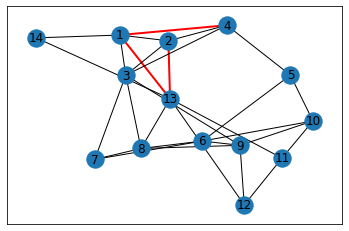

In [4]:
# Visualize the newly created "shortcute" on the graph

added_edges = list(set(edges_after) - set(edges_before))

# let's color these edges and draw the graph again
colors = ['r' if edge in added_edges else 'k' for edge in G.edges()]
widths = [2 if edge in added_edges else 1 for edge in G.edges()]
networkx.draw_networkx(G,with_labels=True,width=widths, edge_color=colors)

In [5]:
# Reformat ED list to hierarchy for search purposes
hierarchical_order = dict()
for order, node in enumerate(edge_difference):
    hierarchical_order[node[0]] = order
    
hierarchical_order

{8: 0,
 10: 1,
 5: 2,
 7: 3,
 11: 4,
 14: 5,
 2: 6,
 1: 7,
 6: 8,
 13: 9,
 4: 10,
 12: 11,
 3: 12,
 9: 13}

Let's now find the shortest path from $8$ to $12$, using Dijkstra's with contraction hierarchy.

In [6]:
source = 8
destination = 12

In [7]:
# Generating the upward graph

# initializing 
SP_s = dict()
parent_s = dict()
unrelaxed_s = list()
for node in G.nodes():
    SP_s[node] = math.inf
    parent_s[node] = None
    unrelaxed_s.append(node)
SP_s[source] = 0

# dijkstra
while unrelaxed_s:
    node = min(unrelaxed_s, key = lambda node : SP_s[node])
    unrelaxed_s.remove(node)
    if SP_s[node] == math.inf: break
    for child in G[node]:
        # skip unqualified edges
        if hierarchical_order[child] < hierarchical_order[node]: continue
        distance = SP_s[node] + G[node][child]['weight']
        if distance < SP_s[child]:
            SP_s[child] = distance
            parent_s[child] = node

In [8]:
# Generating the downward graph

# initializing 
SP_t = dict()
parent_t = dict()
unrelaxed_t = list()
for node in G.nodes():
    SP_t[node] = math.inf
    parent_t[node] = None
    unrelaxed_t.append(node)
SP_t[destination] = 0

# dijkstra
while unrelaxed_t:
    node = min(unrelaxed_t, key = lambda node : SP_t[node])
    unrelaxed_t.remove(node)
    if SP_t[node] == math.inf: break
    for child in G[node]:
        # skip unqualified edges
        if hierarchical_order[child] < hierarchical_order[node]: continue
        distance = SP_t[node] + G[node][child]['weight']
        if distance < SP_t[child]:
            SP_t[child] = distance
            parent_t[child] = node


With these, we now merge the common settled nodes from `SP_d` and `SP_s`, and find the minimum sum of values, This is our shortest path: the collision between the forward and backward expansions.

In [9]:
minimum = math.inf
merge_node = None
for i in SP_s:
    if SP_t[i] == math.inf: continue
    if SP_t[i] + SP_s[i] < minimum:
        minimum = SP_t[i] + SP_s[i]
        merge_node = i

print("Minimum:",minimum)
print("Merge node:",merge_node)

Minimum: 3
Merge node: 9


Let's compare this to `networkx`'s built in solver:

In [ ]:
from networkx.algorithms.shortest_paths.weighted import single_source_dijkstra
single_source_dijkstra(G,source, destination)

#### Pruning

We can actually check to see how many nodes were "pruned" from our graph, using the upward and downward graphs generated earlier.

In [10]:
unvisited = 0
for s_node, s_dist in SP_s.items():
    for t_node, t_dist in SP_t.items():
        if s_node == t_node and s_dist == t_dist == math.inf:
            unvisited += 1
print(f"""Skipped {unvisited} nodes from a graph with {len(G)} total nodes,
resulting in pruning {unvisited/len(G)*100}% of the nodes in our search space.""")

Skipped 7 nodes from a graph with 14 total nodes,
resulting in pruning 50.0% of the nodes in our search space.


---

### Example #2: Equestrian Statue to Bahen Centre using Contraction Hierarchy

We can also use the same method to calculate the shortest path between our statue and lecture hall.

Contraction hierarchies typically require incredibly powerful processing resources to run, especially when dealing with larger scales. Our ED function runs in $O(n^2)$ time, so for a graph of size 1,189 (our University of Toronto map), this requires 1,413,721 runs of `dijkstra_with_contraction`, which itself takes ~0.1 s per call. This would mean just calculating the ED would take 39 hours!

For this example, we've leveraged the use of some HPC (High-performance computing) resources to be able to generate the ED list in a more reasonable amount of time.

@TODO Here